In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
import scipy.special

# NLSYM DATA

In [3]:
# Preprocess data
df = pd.read_csv("data/card.csv")
data_filter = df['educ'].values >= 6
T = df['educ'].values[data_filter]
Z = df['nearc4'].values[data_filter]
y = df['lwage'].values[data_filter]

# Impute missing values with mean, add dummy columns
# I excluded the columns 'weights' as we don't know what it is
X_df = df[['exper', 'expersq']].copy()
X_df['fatheduc'] = df['fatheduc'].fillna(value=df['fatheduc'].mean())
X_df['fatheduc_nan'] = df['fatheduc'].isnull()*1
X_df['motheduc'] = df['motheduc'].fillna(value=df['motheduc'].mean())
X_df['motheduc_nan'] = df['motheduc'].isnull()*1
X_df[['momdad14', 'sinmom14', 'reg661', 'reg662',
        'reg663', 'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669', 'south66']] = df[['momdad14', 'sinmom14', 
        'reg661', 'reg662','reg663', 'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669', 'south66']]
X_df[['black', 'smsa', 'south', 'smsa66']] = df[['black', 'smsa', 'south', 'smsa66']]
columns_to_scale = ['fatheduc', 'motheduc', 'exper', 'expersq']
scaler = StandardScaler()
X_raw = X_df.values[data_filter]
X_df[columns_to_scale] = scaler.fit_transform(X_df[columns_to_scale])
X = X_df.values[data_filter]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [4]:
X_df.columns

Index(['exper', 'expersq', 'fatheduc', 'fatheduc_nan', 'motheduc',
       'motheduc_nan', 'momdad14', 'sinmom14', 'reg661', 'reg662', 'reg663',
       'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669', 'south66',
       'black', 'smsa', 'south', 'smsa66'],
      dtype='object')

# 2. Semi-Synthetic Data with Binary Instrument and Continuous Treatment

Data generating process uning real covariates $X$ and instrument $Z$, but synthetic $y$ and $T$ based on the "intent to treat" instrument setting with non-compliance. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability also depends on an unobserved confounder that has a direct effect on the outcome. Moreover, compliance also depends on the observed feature $X$.

\begin{align}
X \tag{ real features}\\
Z \tag{real instrument}\\
\nu \sim \; & \text{U}[0, 1] \tag{unobserved confounder}\\
C = \; & c\cdot X[i], \; c \;(const)\sim \text{U}[.2, .3] \tag{compliance degree}\\
T = \; & C\cdot Z + g(X) + \nu  \tag{treatment}\\
y \sim \; & \text{Normal}(\mu=\theta(X) \cdot (T + \nu) + f(X),\; \sigma=.1) \tag{outcome}
\end{align}

Moreover:
\begin{align}
\theta(X) = \; & \alpha + \beta \cdot X[i] \tag{CATE}\\
f(X) = \; & X[i] \tag{Nuissance function}\\
g(X) = \; & X[i] \tag{Nuissance function}
\end{align}


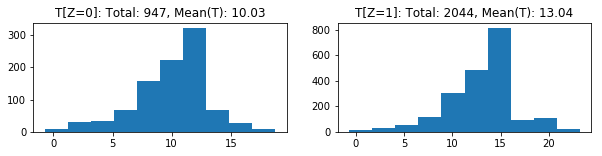

In [5]:
def dgp_bin_Z_cont_T(X, Z, hetero_col, true_fn, random_seed=None):
    np.random.seed(random_seed)
    n, d = X.shape
    nu = np.random.uniform(-1, 1, size=(n,))
    c = np.random.uniform(0.2, 0.3)
    C = c * X[:, hetero_col] # Compliers when recomended
    T = C * Z + X[:, hetero_col] + nu # Treatment with compliance
    y = true_fn(X) * (T + nu)  + 0.05*X[:, hetero_col] + np.random.normal(0, .1, size=(n,))
    return y, T

hetero_col = 4 # Mother's education
hetero_col_2 = 7
true_fn = lambda X: 0.1 + 0.05*X[:, hetero_col] - 0.1*X[:, hetero_col_2]

np.random.seed(1237)
y, T = dgp_bin_Z_cont_T(X_raw, Z, hetero_col, true_fn)

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(T[Z==0])
plt.title("T[Z=0]: Total: {}, Mean(T): {:.2f}".format(T[Z==0].shape[0], np.mean(T[Z==0])))
plt.subplot(1, 2, 2)
plt.hist(T[Z==1])
plt.title("T[Z=1]: Total: {}, Mean(T): {:.2f}".format(T[Z==1].shape[0], np.mean(T[Z==1])))
plt.show()

# ANALYSIS

### Defining some hyperparameters

In [6]:
random_seed = 12345 # random seed for each experiment
N_SPLITS = 10 # number of splits for cross-fitting
COV_CLIP = 20/X.shape[0] # covariance clipping in driv
print(COV_CLIP)

0.006686726847208292


### Defining some generic non-parametric regressors and classifiers

In [7]:
from utilities import RegWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from xgboost import XGBClassifier, XGBRegressor
from xgb_utilities import XGBWrapper

# Linear models for regression and classification 
model = lambda: Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                          ('lasso', LassoCV(cv=3, n_jobs=-1))])
model_clf = lambda: RegWrapper(Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                                    ('logistic', LogisticRegressionCV(cv=3, solver='liblinear',
                                                                      scoring='neg_log_loss', n_jobs=-1))]))

### Some utility functions

In [8]:
def nuisance_diagnostic(cate, nuisance_model, property_name, property_fn, 
                        index_names=None, statistic=np.std, threshold=None):
    std = statistic([property_fn(ns) for ns in cate.fitted_nuisances[nuisance_model]], axis=0)
    if hasattr(std, '__len__'):
        if threshold is None:
            coefs = np.argmax(std).flatten()
        else:
            coefs = np.argwhere(std >= threshold).flatten()
        if index_names is None:
            index_names = np.arange(std.shape[0])
        for high_var in coefs:
            plt.title("{}: {}[{}] Across Folds".format(nuisance_model, property_name, index_names[high_var]))
            plt.plot([property_fn(ns)[high_var] for ns in cate.fitted_nuisances[nuisance_model]])
            plt.xlabel('fold')
            plt.ylabel('property')
            plt.show()
    else:
        plt.title("{}: {} Across Folds".format(nuisance_model, property_name))    
        plt.plot([property_fn(ns) for ns in cate.fitted_nuisances[nuisance_model]])
        plt.xlabel('fold')
        plt.ylabel('property')
        plt.show()
    

# ATE via DMLATEIV

In [9]:
from dml_ate_iv import DMLATEIV

np.random.seed(random_seed)

# We need to specify models to be used for each of these residualizations
model_Y_X = lambda: model() # model for E[Y | X]
model_T_X = lambda: model() # model for E[T | X]. We use a regressor since T is continuous
model_Z_X = lambda: model_clf() # model for E[Z | X]. We use a classifier since Z is binary

dmlate = DMLATEIV(model_Y_X(), model_T_X(), model_Z_X(),
                  n_splits=N_SPLITS, # n_splits determines the number of splits to be used for cross-fitting.
                  binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                  binary_treatment=False # a flag whether to stratify cross-fitting by treatment
                 )

C:\ProgramData\Anaconda3\lib\site-packages\numba\errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [10]:
# We fit DMLATEIV with these models
dmlate.fit(y, T, X, Z)

In [11]:
# We call effect() to get the ATE
ta_effect = dmlate.effect()

In [12]:
# Comparison with true ATE
print("ATE Estimate: {:.3f}".format(ta_effect))
print("True ATE: {:.3f}".format(np.mean(true_fn(X_raw))))
# CATE MSE
print("CATE MSE: {:.2f}".format(np.mean((true_fn(X_raw) - ta_effect)**2)))

ATE Estimate: 0.651
True ATE: 0.609
CATE MSE: 0.03


In [13]:
# We can call normal_effect_interval to get confidence intervals based
# based on the asympotic normal approximation
ta_effect = dmlate.normal_effect_interval(lower=2.5, upper=97.5)
# Comparison with true ATE
print("ATE Estimate Interval: ({:.3f}, {:.3f})".format(ta_effect[0], ta_effect[1]))
print("True ATE: {:.3f}".format(np.mean(true_fn(X_raw))))

ATE Estimate Interval: (0.607, 0.696)
True ATE: 0.609


In [14]:
def get_dmlateiv_coverage(true_effect, iteration):
    y, T = dgp_bin_Z_cont_T(X_raw, Z, hetero_col, true_fn, random_seed=iteration)
    dmlate = DMLATEIV(model_Y_X(), model_T_X(), model_Z_X(),
                  n_splits=N_SPLITS, # n_splits determines the number of splits to be used for cross-fitting.
                  binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                  binary_treatment=False # a flag whether to stratify cross-fitting by treatment
                 )
    dmlate.fit(y, T, X, Z)
    left, right = dmlate.normal_effect_interval(lower=2.5, upper=97.5)
    if true_effect >= left and true_effect <= right:
        return 1
    return 0

from joblib import Parallel, delayed
n_experiments=100
true_ate = np.mean(true_fn(X_raw))
if True:
    contains_truth = np.array(Parallel(n_jobs=-1, verbose=3)(
            delayed(get_dmlateiv_coverage)(true_ate, it) for it in range(n_experiments)))
    print("Coverage: {}".format(contains_truth.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min


Coverage: 0.52


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished


# ATE and CATE via DMLIV

In [15]:
from dml_iv import DMLIV
from utilities import SelectiveLasso, SeparateModel
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from econml.utilities import hstack

np.random.seed(random_seed)

# For DMLIV we also need a model for E[T | X, Z]. To allow for heterogeneity in the compliance, i.e.
# T = beta(X)*Z + gamma(X)
# we train a separate model for Z=1 and Z=0. The model for Z=1 learns the
# quantity beta(X) + gamma(X) and the model for Z=0 learns gamma(X).
model_T_XZ = lambda: SeparateModel(model(), model())

# We now specify the features to be used for heterogeneity. We will fit a CATE model of the form
#      theta(X) = <theta, phi(X)>
# for some set of features phi(X). The featurizer needs to support fit_transform, that takes
# X and returns phi(X). We need to include a bias if we also want a constant term.
dmliv_featurizer = lambda: PolynomialFeatures(degree=1, include_bias=True)

# Then we need to specify a model to be used for fitting the parameters theta in the linear form.
# This model will minimize the square loss:
#        (Y - E[Y|X] - <theta, phi(X)> * (E[T|X,Z] - E[T|X]))**2
#dmliv_model_effect = lambda: LinearRegression(fit_intercept=False)


# Potentially with some regularization on theta. Here we use an ell_1 penalty on theta
# If we also have a prior that there is no effect heterogeneity we can use a selective lasso
# that does not penalize the constant term in the CATE model
dmliv_model_effect = lambda: SelectiveLasso(np.arange(1, X.shape[1]+1), LassoCV(cv=5, fit_intercept=False))


# We initialize DMLIV with all these models and call fit
cate = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(), 
             dmliv_model_effect(), dmliv_featurizer(),
             n_splits=N_SPLITS, # number of splits to use for cross-fitting
             binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
             binary_treatment=False # a flag whether to stratify cross-fitting by treatment
            )

In [16]:
cate.fit(y, T, X, Z)

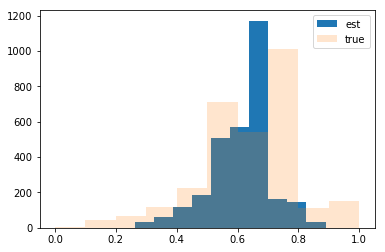

In [17]:
# To get the CATE at every X we call effect(X)
dml_effect = cate.effect(X)
plt.hist(dml_effect, label='est')
plt.hist(true_fn(X_raw), alpha=.2, label='true')
plt.legend()
plt.show()

In [18]:
# To get the parameter theta we call coef_. The first entry is the intercept of the CATE model
print(cate.coef_)

[ 0.62317714  0.          0.          0.         -0.          0.10377389
 -0.          0.         -0.         -0.          0.          0.
 -0.         -0.         -0.         -0.          0.          0.
 -0.          0.          0.         -0.          0.        ]


In [19]:
# We can average the CATE to get an ATE
print("ATE Estimate: {:.3f}".format(np.mean(dml_effect)))
print("True ATE: {:.3f}".format(np.mean(true_fn(X_raw))))

ATE Estimate: 0.624
True ATE: 0.609


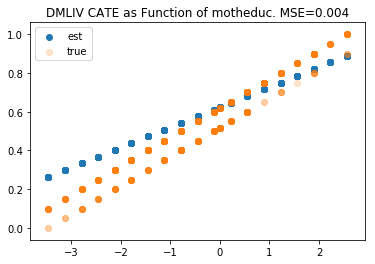

In [20]:
# We can also see how it compares to the true CATE at each target point and calculate MSE
plt.title("DMLIV CATE as Function of {}. MSE={:.3f}".format(X_df.columns[4], np.mean((dml_effect-true_fn(X_raw))**2)))
plt.scatter(X[:, 4], dml_effect, label='est')
plt.scatter(X[:, 4], true_fn(X_raw), label='true', alpha=.2)
plt.legend()
plt.show()

# ATE and Projected CATE via DRIV

In [21]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper, StatsModelLinearRegression, ConstantModel
from sklearn.dummy import DummyRegressor

np.random.seed(random_seed)

# For DRIV we need a model for predicting E[T*Z | X]. We use a classifier
model_TZ_X = lambda: model()

# We also need a model for the final regression that will fit the function theta(X)
# If we want to fit an ATE, we simply fit a constant functin theta(X) = theta
# We can do this with a pipeline where the preprocessing step only creates a bias column
# and the regression step fits a linear regression with no intercept.
# To get normal confidence intervals easily we can use a statsmodels linear regression
# wrapped in an sklearn interface
const_driv_model_effect = lambda: ConstantModel()

# As in OrthoDMLIV we need a perliminary estimator of the CATE.
# We use a DMLIV estimator with no cross-fitting (n_splits=1)
dmliv_prel_model_effect = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(),
                                dmliv_model_effect(), dmliv_featurizer(),
                                n_splits=1, binary_instrument=True, binary_treatment=False)

const_dr_cate = DRIV(model_Y_X(), model_T_X(), model_Z_X(), # same as in DMLATEIV
                        dmliv_prel_model_effect, # preliminary model for CATE, must support fit(y, T, X, Z) and effect(X)
                        model_TZ_X(), # model for E[T * Z | X]
                        const_driv_model_effect(), # model for final stage of fitting theta(X)
                        cov_clip=COV_CLIP, # covariance clipping to avoid large values in final regression from weak instruments
                        n_splits=N_SPLITS, # number of splits to use for cross-fitting
                        binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                        binary_treatment=False, # a flag whether to stratify cross-fitting by treatment
                        opt_reweighted=False # whether to optimally re-weight samples. Valid only for flexible final model
                       )

In [22]:
const_dr_cate.fit(y, T, X, Z, store_final=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

In [23]:
# To get the statsmodel summary we look at the effect_model, which is the pipeline, we then look
# at the reg step of the pipeline which is the statsmodel wrapper and then we look
# at the model attribute of the statsmodel wrapper and print the summary()
const_dr_cate.effect_model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 01 Jun 2019   Prob (F-statistic):                nan
Time:                        15:27:35   Log-Likelihood:                -7831.2
No. Observations:                2991   AIC:                         1.566e+04
Df Residuals:                    2990   BIC:                         1.567e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5458      0.061      8.995      0.000       0.427       0.665
==============================================================================
Omnibus:                     4190.040   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8408463.090
Skew:                          -7.266   Prob(JB):                         0.00
Kurtosis:                     262.343   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
def get_driv_coverage(true_effect, iteration):
    y, T = dgp_bin_Z_cont_T(X_raw, Z, hetero_col, true_fn, random_seed=iteration)
    dmliv_prel_model_effect = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(),
                                dmliv_model_effect(), dmliv_featurizer(),
                                n_splits=1, binary_instrument=True, binary_treatment=True)
    const_dr_cate = DRIV(model_Y_X(), model_T_X(), model_Z_X(), # same as in DMLATEIV
                            dmliv_prel_model_effect, # preliminary model for CATE, must support fit(y, T, X, Z) and effect(X)
                            model_TZ_X(), # model for E[T * Z | X]
                            const_driv_model_effect(), # model for final stage of fitting theta(X)
                            cov_clip=COV_CLIP, # covariance clipping to avoid large values in final regression from weak instruments
                            n_splits=N_SPLITS, # number of splits to use for cross-fitting
                            binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                            binary_treatment=False # a flag whether to stratify cross-fitting by treatment
                           )
    const_dr_cate.fit(y, T, X, Z, store_final=True)
    left, right = const_dr_cate.effect_model.est.model.conf_int(alpha=0.05)[0]
    if true_effect >= left and true_effect <= right:
        return 1
    return 0

In [25]:
from joblib import Parallel, delayed
n_experiments=100
true_ate = np.mean(true_fn(X_raw))
if True:
    contains_truth = np.array(Parallel(n_jobs=-1, verbose=3)(
            delayed(get_driv_coverage)(true_ate, it) for it in range(n_experiments)))
    print("Coverage: {}".format(contains_truth.mean()))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.3min


Coverage: 0.98


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.3min finished


## Projecting CATE to a pre-chosen subset of variables in final model

In [26]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper

np.random.seed(random_seed)

# We could also fit a projection on a subset of the features by using the
# subset wrapper from our utilities.

# Example: including everything for expository purposes, but any array-like of indices would work
subset_names = set(['motheduc', 'sinmom14'])
# list of indices of features X to use in the final model
feature_inds = np.argwhere([(x in subset_names) for x in X_df.columns.values]).flatten() #[0] #np.arange(X.shape[1]) 
print(feature_inds)
# Because we are projecting to a low dimensional model space, we can
# do valid inference and we can use statsmodel linear regression to get all
# the hypothesis testing capability
proj_driv_model_effect = lambda: SubsetWrapper(StatsModelLinearRegression(),
                                          feature_inds # list of indices of features X to use in the final model
                                         )

[4 7]


In [27]:
X_df.columns

Index(['exper', 'expersq', 'fatheduc', 'fatheduc_nan', 'motheduc',
       'motheduc_nan', 'momdad14', 'sinmom14', 'reg661', 'reg662', 'reg663',
       'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669', 'south66',
       'black', 'smsa', 'south', 'smsa66'],
      dtype='object')

In [28]:
proj_dr_cate = const_dr_cate.refit_final(proj_driv_model_effect())

In [29]:
# To get the CATE at every X we call effect(X[:, feature_inds])
proj_dr_effect = proj_dr_cate.effect(X[:, feature_inds])

In [30]:
# To get the statsmodel summary we look at the effect_model, which is
# an instance of SubsetWrapper, we look at the model of the SubsetWrapper which is 
# and instance of the pipeline, we then look at the reg step of the pipeline which is the statsmodel wrapper and
# call summary() of the wrapper (most prob there is a better API for this, but we can go with this for now :)
proj_dr_cate.effect_model.summary(alpha=.05, xname=['const']+list(X_df.columns[feature_inds]))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.637
Date:                Sat, 01 Jun 2019   Prob (F-statistic):             0.0717
Time:                        15:38:55   Log-Likelihood:                -7828.6
No. Observations:                2991   AIC:                         1.566e+04
Df Residuals:                    2988   BIC:                         1.568e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5561      0.064      8.684      0.000       0.431       0.682
motheduc       0.1310      0.062      2.121      0.034       0.010       0.252
sinmom14      -0.1149      0.204     -0.563      0.573      -0.515       0.285
==============================================================================
Omnibus:                     4157.081   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8324885.444
Skew:                          -7.146   Prob(JB):                         0.00
Kurtosis:                     261.061   Cond. No.                         3.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# We can access the coefficient by looking at the coefficient attribute of the final step of the pipeline
print("Estimated Params: {}, {}".format(proj_dr_cate.intercept_, proj_dr_cate.coef_))
# True coefficients of projection
print("True Params: {}".format(
        LinearRegression(fit_intercept=False).fit(PolynomialFeatures(degree=1,
                                                                     include_bias=True).fit_transform(X[:, feature_inds]),
                                                  true_fn(X_raw)).coef_))

Estimated Params: 0.5560648374345198, [ 0.13103506 -0.11489838]
True Params: [ 0.61740685  0.14934234 -0.1       ]


Coverage of True Projection: 1.00


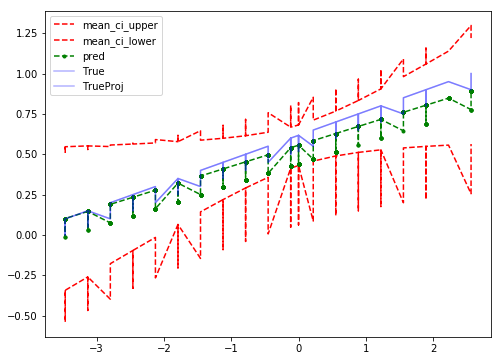

In [32]:
# We can also evaluate coverage and create prediction intervals using statsmodels attributes
from statsmodels.sandbox.regression.predstd import wls_prediction_std
res = proj_dr_cate.effect_model.model
predictions = res.get_prediction(PolynomialFeatures(degree=1, include_bias=True).fit_transform(X[:, feature_inds]))
frame = predictions.summary_frame(alpha=0.05)
pred = frame['mean']
iv_l = frame['mean_ci_lower']
iv_u = frame['mean_ci_upper']

# This is the true CATE functions
theta_true = true_fn(X_raw)
# This is the true projection of the CATE function on the subspace of linear functions of the
# subset of the features used in the projection
true_proj = LinearRegression().fit(X[:, feature_inds], theta_true).predict(X[:, feature_inds])

# Are we covering the true projection
covered = (true_proj <= iv_u) & (true_proj >= iv_l)
print("Coverage of True Projection: {:.2f}".format(np.mean(covered)))

fig, ax = plt.subplots(figsize=(8,6))

order = np.argsort(X[:, feature_inds[0]])
ax.plot(X[order, feature_inds[0]], iv_u[order], 'r--')
ax.plot(X[order, feature_inds[0]], iv_l[order], 'r--')
ax.plot(X[order, feature_inds[0]], pred[order], 'g--.', label="pred")
ax.plot(X[order, feature_inds[0]], theta_true[order], 'b-', label="True", alpha=.3)
ax.plot(X[order, feature_inds[0]], true_proj[order], 'b-', label="TrueProj", alpha=.3)
ax.legend(loc='best')
plt.show()

# CATE via Re-Weighted DRIV: DRIV-RW

## Lasso CATE

In [33]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper, StatsModelLinearRegression, ConstantModel, WeightWrapper
from sklearn.dummy import DummyRegressor

np.random.seed(random_seed)

# For DRIV we need a model for predicting E[T*Z | X]. We use a classifier
model_TZ_X = lambda: model()

# We also need a model for the final regression that will fit the function theta(X)
# This model now needs to accept sample weights at fit time.
const_driv_model_effect = lambda: WeightWrapper(Pipeline([('bias', PolynomialFeatures(degree=1, include_bias=True)),
                                                          ('reg', SelectiveLasso(np.arange(1, X.shape[1]+1),
                                                                                  LassoCV(cv=5, fit_intercept=False)))]))

# As in OrthoDMLIV we need a perliminary estimator of the CATE.
# We use a DMLIV estimator with no cross-fitting (n_splits=1)
dmliv_prel_model_effect = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(),
                                dmliv_model_effect(), dmliv_featurizer(),
                                n_splits=1, binary_instrument=True, binary_treatment=False)

const_dr_cate = DRIV(model_Y_X(), model_T_X(), model_Z_X(), # same as in DMLATEIV
                        dmliv_prel_model_effect, # preliminary model for CATE, must support fit(y, T, X, Z) and effect(X)
                        model_TZ_X(), # model for E[T * Z | X]
                        const_driv_model_effect(), # model for final stage of fitting theta(X)
                        cov_clip=COV_CLIP, # covariance clipping to avoid large values in final regression from weak instruments
                        n_splits=N_SPLITS, # number of splits to use for cross-fitting
                        binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                        binary_treatment=False, # a flag whether to stratify cross-fitting by treatment
                        opt_reweighted=True # whether to optimally re-weight samples. Valid only for flexible final model
                       )

In [34]:
const_dr_cate.fit(y, T, X, Z, store_final=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

In [35]:
# We can average the CATE to get an ATE
dr_effect = const_dr_cate.effect(X)
print("ATE Estimate: {:.3f}".format(np.mean(dr_effect)))
print("True ATE: {:.3f}".format(np.mean(true_fn(X_raw))))

ATE Estimate: 0.612
True ATE: 0.609


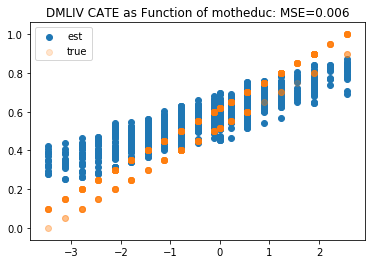

In [36]:
# We can also see how it compares to the true CATE at each target point and calculate MSE
plt.title("DMLIV CATE as Function of {}: MSE={:.3f}".format(X_df.columns[4], np.mean((dr_effect-true_fn(X_raw))**2)))
plt.scatter(X[:, 4], dr_effect, label='est')
plt.scatter(X[:, 4], true_fn(X_raw), label='true', alpha=.2)
plt.legend()
plt.show()

## Random Forest CATE

In [37]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    
np.random.seed(random_seed)

rf_driv_model_effect = lambda: RandomForestRegressor(n_estimators=5000, max_depth=3, min_impurity_decrease=0.00001,
                                                     min_samples_leaf=100, bootstrap=True)

In [38]:
rf_dr_cate = const_dr_cate.refit_final(rf_driv_model_effect())

In [39]:
rf_dr_effect = rf_dr_cate.effect(X)

In [40]:
print("ATE Estimate: {:.2f}".format(np.mean(rf_dr_effect)))
print("True ATE: {:.2f}".format(np.mean(true_fn(X_raw))))

ATE Estimate: 0.63
True ATE: 0.61


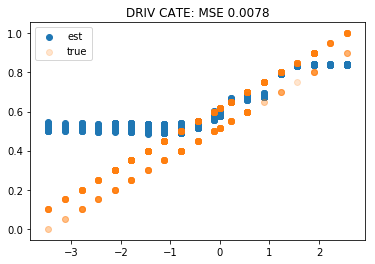

In [41]:
plt.title("DRIV CATE: MSE {:.2}".format(np.mean((true_fn(X_raw) - rf_dr_effect)**2)))
plt.scatter(X[:, 4], rf_dr_effect, label='est')
plt.scatter(X[:, 4], true_fn(X_raw), label='true', alpha=.2)
plt.legend()
plt.show()

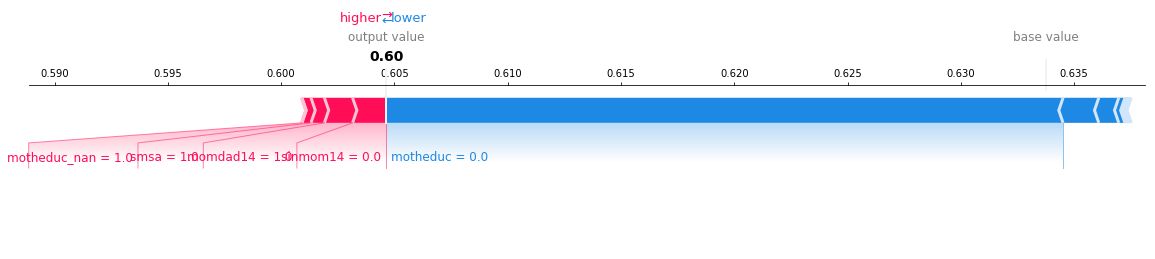

In [42]:
import shap
import pandas as pd

Xdf = pd.DataFrame(X, columns=X_df.columns)
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rf_dr_cate.effect_model)
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

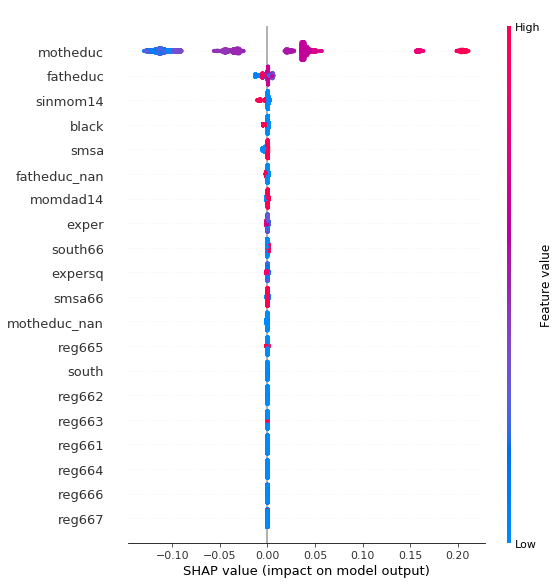

In [43]:
shap.summary_plot(shap_values, Xdf)

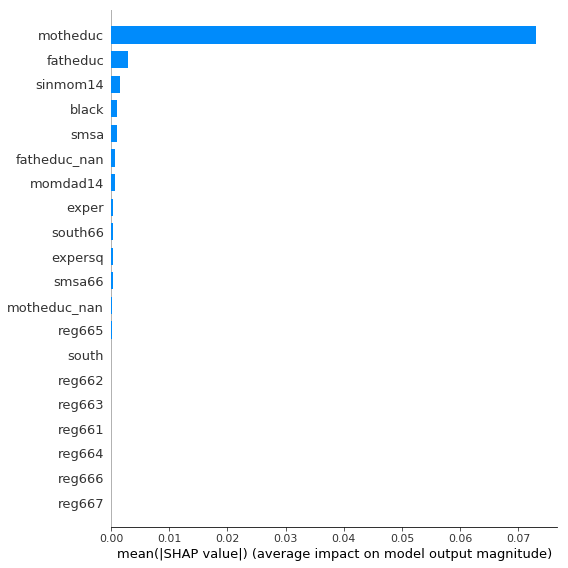

In [44]:
shap.summary_plot(shap_values, Xdf, plot_type='bar')